<a href="https://colab.research.google.com/github/CarlosHenriqueMatos/dataExplorationAndML/blob/main/UnetTamanhoNormal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install tensorflow-addons
!pip install imagecodecs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 4.6 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.4.1
    Uninstalling typeguard-4.4.1:
      Successfully uninstalled typeguard-4.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.4.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 MB 13.0 MB/s eta 0:00:00


In [4]:
import os
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
import keras.layers as layers
from keras.models import Model
from keras import backend as K
from skimage.io import imread, imshow
from skimage.transform import resize

import warnings
warnings.filterwarnings('ignore')

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
IMG_HEIGHT = 128
IMG_WIDTH = 128
IMG_CHANNELS = 3

In [40]:
# get a list of files in each folder

img_list = os.listdir('/content/drive/MyDrive/IFES_2023/AMAZON/Backup_Dataset/Training/image/')
mask_list = os.listdir('/content/drive/MyDrive/IFES_2023/AMAZON/Backup_Dataset/Training/label/')

# create a dataframe
train_df_images = pd.DataFrame(img_list, columns=['image_id'])
train_df_mask = pd.DataFrame(mask_list, columns=['image_id'])

# get a list of files in each folder

validation_img_list = os.listdir('/content/drive/MyDrive/IFES_2023/AMAZON/Backup_Dataset/Validation/images/')
validation_mask_list = os.listdir('/content/drive/MyDrive/IFES_2023/AMAZON/Backup_Dataset/Validation/masks/')

# create a dataframe
validation_df_images = pd.DataFrame(validation_img_list, columns=['image_id'])
validation_df_mask = pd.DataFrame(validation_mask_list, columns=['image_id'])

In [7]:
# Get lists of images and their masks.
train_image_list = list(train_df_images['image_id'])
train_mask_list = list(train_df_mask['image_id'])
validation_image_list = list(validation_df_images['image_id'])
validation_mask_list = list(validation_df_mask['image_id'])
# Create empty arrays

X_train = np.zeros((len(train_image_list), IMG_HEIGHT, IMG_WIDTH,3), dtype=np.float16)#You can use float16 or 32, enhance the precision
Y_train = np.zeros((len(train_mask_list), IMG_HEIGHT, IMG_WIDTH), dtype=np.uint8)
X_val = np.zeros((len(validation_image_list), IMG_HEIGHT, IMG_WIDTH,3), dtype=np.float16)
Y_val = np.zeros((len(validation_mask_list), IMG_HEIGHT, IMG_WIDTH), dtype=np.uint8)

In [8]:
num_images = len(train_image_list)
# Pré-aloque o array
X_train = np.zeros((num_images, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float16)

for i, img_id in tqdm(enumerate(train_image_list)):
    path_mask = '/content/drive/MyDrive/IFES_2023/AMAZON/Backup_Dataset/Training/image/' + img_id
    image = cv2.imread(path_mask, 3)  # Usa a flag correta
    stretch_near = cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH),
              interpolation = cv2.INTER_LINEAR)
    X_train[i] = stretch_near  # Adiciona diretamente ao array

499it [00:51,  9.70it/s]


In [9]:
num_images = len(train_image_list)

# Pré-aloque um array para as máscaras
Y_train = np.zeros((num_images, IMG_HEIGHT, IMG_WIDTH), dtype=np.uint8)

for i, img_id in tqdm(enumerate(train_image_list)):
    path_mask = '/content/drive/MyDrive/IFES_2023/AMAZON/Backup_Dataset/Training/label/' + img_id
    image = cv2.imread(path_mask, 0)  # Ler como escala de cinza
    stretch_near = cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH),
               interpolation = cv2.INTER_LINEAR)
    Y_train[i] = stretch_near  # Adicionar diretamente ao array

499it [03:57,  2.10it/s]


In [10]:
num_images = len(validation_image_list)

# Pré-aloque o array
X_val = np.zeros((num_images, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float16)

for i, img_id in tqdm(enumerate(validation_image_list)):
    path_mask = '/content/drive/MyDrive/IFES_2023/AMAZON/Backup_Dataset/Validation/images/' + img_id
    image = cv2.imread(path_mask, 3)  # Usa a flag correta
    stretch_near = cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH),
              interpolation = cv2.INTER_LINEAR)
    X_val[i] = stretch_near  # Adiciona diretamente ao array

4it [00:04,  1.11s/it]


KeyboardInterrupt: 

In [ ]:
num_images = len(validation_image_list)

# Pré-aloque um array para as máscaras
Y_val = np.zeros((num_images, IMG_HEIGHT, IMG_WIDTH), dtype=np.uint8)

for i, img_id in tqdm(enumerate(validation_image_list)):
    path_mask = '/content/drive/MyDrive/IFES_2023/AMAZON/Backup_Dataset/Validation/masks/' + img_id
    image = cv2.imread(path_mask, 0)  # Ler como escala de cinza
    stretch_near = cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH),
               interpolation = cv2.INTER_LINEAR)
    Y_train[i] = stretch_near  # Adicionar diretamente ao array

In [8]:

from keras.models import Model, load_model
from keras.layers import Input
from tensorflow.keras.layers import Dropout, Lambda
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, concatenate, Lambda
from tensorflow.keras.models import Model

In [9]:

def plota_grafico(historico):
    # figure(figsize = (8, 6))
    ###################### losss
    plt.plot(historico.history['loss'])
    plt.plot(historico.history['val_loss'])
    plt.title('LOSS')
    plt.ylim(ymin = 0,ymax = 1)

    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc ='upper left')

    plt.grid()
    plt.show()

    ###################### acuracia

    plt.plot(historico.history['f1_score'])
    plt.plot(historico.history['val_f1_score'])
    plt.title('F1 Score')
    plt.ylim(ymin = 0,ymax = 1)

    plt.ylabel('F1 Score')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc ='upper left')

    plt.grid()
    plt.show()

In [10]:
pip install scikeras


In [11]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy, Metric
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler

In [12]:
class F1Score(Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = Precision()
        self.recall = Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        precision = self.precision.result()
        recall = self.recall.result()
        f1_score = 2 * ((precision * recall) / (precision + recall + K.epsilon()))
        return f1_score

    def reset_states(self):
        self.precision.reset_state()
        self.recall.reset_state()

In [13]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_validate
#from keras.wrappers.scikit_learn import KerasClassifier


from sklearn.metrics import make_scorer

# Importando os módulos de cálculo de métricas
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import jaccard_score



In [14]:
print(type(X_train), type(Y_train))
print(X_train.shape, Y_train.shape)

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(499, 128, 128, 3) (499, 128, 128)


In [36]:
from sklearn.base import BaseEstimator
import tensorflow as tf

import os
from tensorflow.keras.callbacks import ModelCheckpoint
# Diretório base




class KerasEstimator(BaseEstimator):
    instance_counter = 0
    def __init__(self, optimizer='adam', learning_rate=0.001, ema_momentum=0.9, kernel_initializer='he_normal'):
        self.learning_rate = learning_rate
        self.ema_momentum = ema_momentum
        self.optimizer = optimizer
        self.kernel_initializer = kernel_initializer
        KerasEstimator.instance_counter += 1  # Initialize the counter

    def load_weights(self, weights_path):
        """
        Load weights into the model from a specified file.
        """
        self.model = self.create_model()
        if not os.path.exists(weights_path):
            raise FileNotFoundError(f"Weight file not found at: {weights_path}")

        if not self.model:
            # Create the model if it doesn't exist
            self.model = self.create_model()

        # Load the weights into the model
        self.model.load_weights(weights_path)
        print(f"Weights loaded successfully from {weights_path}")

    def fit(self, X, y):
        self.model = self.create_model()
        # Nome do arquivo do checkpoint

        base_dir = "/content/drive/MyDrive/Mestrado/2024_2/Qualification"

        # Nome do diretório específico para o checkpoint
        subdir_name = f"{self.optimizer}_{self.learning_rate}_{self.ema_momentum}_{self.kernel_initializer}"

        # Criar o diretório completo
        save_dir = os.path.join(base_dir, subdir_name)
        os.makedirs(save_dir, exist_ok=True)  # Garante que o diretório existe


        filename = f"{self.optimizer}_{self.learning_rate}_{self.ema_momentum}_{self.kernel_initializer}_version_instance_{KerasEstimator.instance_counter}.keras"

        # Caminho completo do arquivo
        filepath = os.path.join(save_dir, filename)

        early_stopper = tf.keras.callbacks.EarlyStopping(
            monitor='accuracy',  # Monitor the f1_score on the validation set
            patience=10,
            verbose=1,
            restore_best_weights=False
        )

        # Callback ModelCheckpoint
        checkpoint = ModelCheckpoint(
            filepath=filepath,
            monitor='accuracy',  # Certifique-se de que "accuracy" é válido no seu modelo
            verbose=1,
            save_best_only=True,
            mode='max'
        )
        history = self.model.fit(X, y, batch_size=32, epochs=1000, verbose=1,callbacks=[early_stopper,checkpoint])


        print("Dados Gravados")

        return self

    def predict(self, X):
        return self.model.predict(X)

    def create_model(self):
        print(self.ema_momentum,self.learning_rate,self.kernel_initializer,self.optimizer)
        inputs = Input((IMG_HEIGHT, IMG_WIDTH, 3))

        s = tf.keras.layers.Lambda(lambda x: x / 65.536) (inputs)

        c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer=self.kernel_initializer, padding='same') (s)
        c1 = tf.keras.layers.Dropout(0.1) (c1)
        c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer=self.kernel_initializer, padding='same') (c1)
        p1 = tf.keras.layers.MaxPooling2D((2, 2)) (c1)

        c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer=self.kernel_initializer, padding='same') (p1)
        c2 = tf.keras.layers.Dropout(0.1) (c2)
        c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer=self.kernel_initializer, padding='same') (c2)
        p2 = tf.keras.layers.MaxPooling2D((2, 2)) (c2)

        c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer=self.kernel_initializer, padding='same') (p2)
        c3 = tf.keras.layers.Dropout(0.2) (c3)
        c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer=self.kernel_initializer, padding='same') (c3)
        p3 = tf.keras.layers.MaxPooling2D((2, 2)) (c3)

        c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer=self.kernel_initializer, padding='same') (p3)
        c4 = tf.keras.layers.Dropout(0.2) (c4)
        c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer=self.kernel_initializer, padding='same') (c4)
        p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2)) (c4)

        c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer=self.kernel_initializer, padding='same') (p4)
        c5 = tf.keras.layers.Dropout(0.3) (c5)
        c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer=self.kernel_initializer, padding='same') (c5)

        u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
        u6 = tf.keras.layers.Concatenate()([u6, c4])  # Fix the Concatenate usage
        c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer=self.kernel_initializer, padding='same')(u6)
        c6 = tf.keras.layers.Dropout(0.2)(c6)
        c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer=self.kernel_initializer, padding='same')(c6)

        u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
        u7 = tf.keras.layers.Concatenate()([u7, c3])  # Fix the Concatenate usage
        c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer=self.kernel_initializer, padding='same')(u7)
        c7 = tf.keras.layers.Dropout(0.2)(c7)
        c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer=self.kernel_initializer, padding='same')(c7)

        u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
        u8 = tf.keras.layers.Concatenate()([u8, c2])  # Fix the Concatenate usage
        c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer=self.kernel_initializer, padding='same')(u8)
        c8 = tf.keras.layers.Dropout(0.1)(c8)
        c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer=self.kernel_initializer, padding='same')(c8)


        u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
        u9 = tf.keras.layers.Concatenate(axis=3)([u9, c1])  # Fix the Concatenate usage
        c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer=self.kernel_initializer, padding='same')(u9)
        c9 = tf.keras.layers.Dropout(0.1)(c9)
        c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer=self.kernel_initializer, padding='same')(c9)

        outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid') (c9)

        model = Model(inputs=[inputs], outputs=[outputs])  # Your model architecture here
        model.compile(optimizer=self.get_optimizer(), loss='binary_crossentropy', metrics=['accuracy'])
        return model

    def get_optimizer(self):
        if self.optimizer == 'adam':
            return tf.keras.optimizers.Adam(learning_rate=self.learning_rate, ema_momentum=self.ema_momentum)
        elif self.optimizer == 'nadam':
            return tf.keras.optimizers.Nadam(learning_rate=self.learning_rate, ema_momentum=self.ema_momentum)
        elif self.optimizer == 'adamw':
            # Implement AdamW optimizer (adjust parameters as needed)
            return tf.keras.optimizers.AdamW(learning_rate=self.learning_rate, ema_momentum=self.ema_momentum)
        else:
            raise ValueError("Unknown optimizer: {}".format(self.optimizer))

# Define hyperparameters for grid search
parameters = {
    'optimizer':['adam'], #['adam','nadam','adamw'],
    'learning_rate': [0.003,0.004],
    'ema_momentum': [0.975],
    'kernel_initializer': ['he_normal']
}

# Create the wrapped KerasEstimator
#cv = KFold(n_splits=5, shuffle=True, random_state=42)  # Use 5-fold cross-validation
clf = GridSearchCV(estimator = KerasEstimator(), param_grid=parameters,scoring = 'f1',cv=5)
#clf.fit(X_train, Y_train)
# Fit the grid search

In [37]:
estimator = KerasEstimator()

In [18]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import cv2
import numpy as np
from sklearn.metrics import confusion_matrix

['adam_0.003_0.975_he_normal_version_instance_3.keras']
0.9 0.001 he_normal adam
Weights loaded successfully from /content/drive/MyDrive/Mestrado/2024_2/Qualification/adam_0.003_0.975_he_normal/adam_0.003_0.975_he_normal_version_instance_3.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 500ms/step


[0.29882812 0.00482178] 
 [0.11401367 0.58233643]


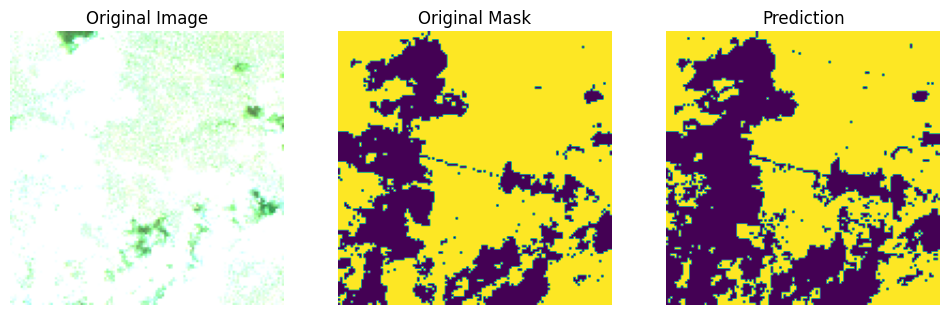

1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


[0.31951904 0.03436279] 
 [0.01599121 0.63012695]


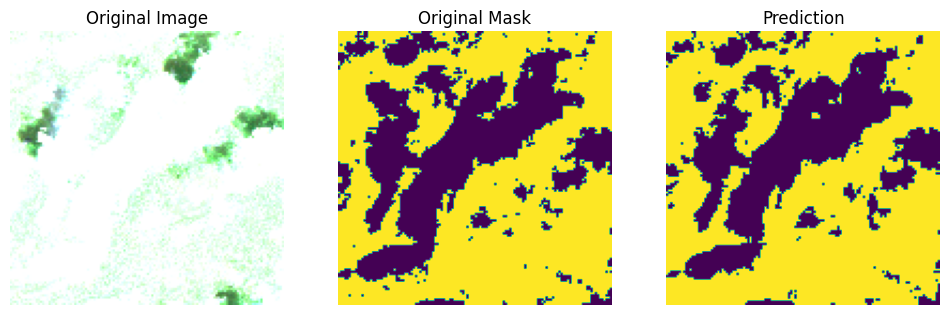

2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


[0.27148438 0.05554199] 
 [0.01550293 0.6574707 ]


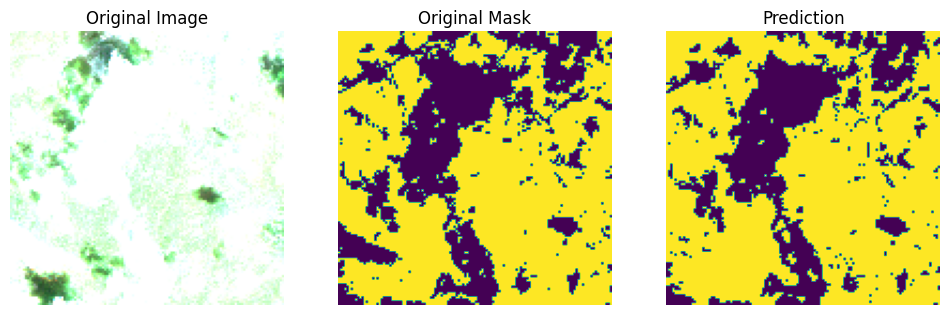

3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


[0.27648926 0.00665283] 
 [0.05053711 0.6663208 ]


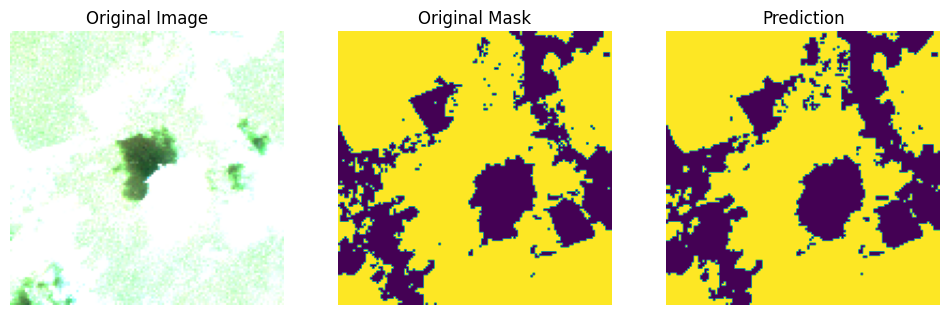

4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


[0.2699585  0.00531006] 
 [0.05560303 0.66912842]


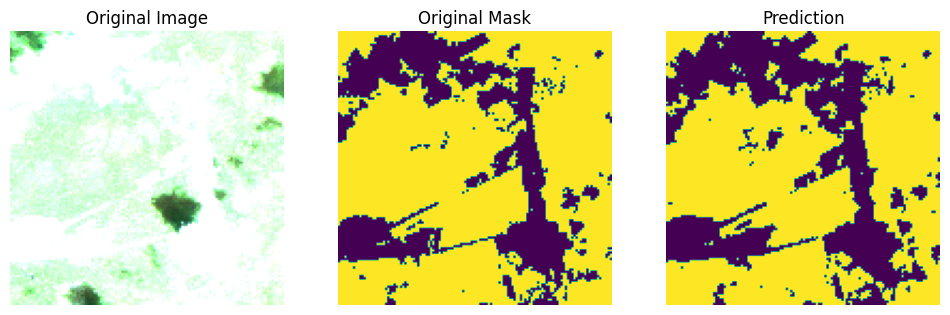

5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


[0.2020874  0.00372314] 
 [0.0869751  0.70721436]


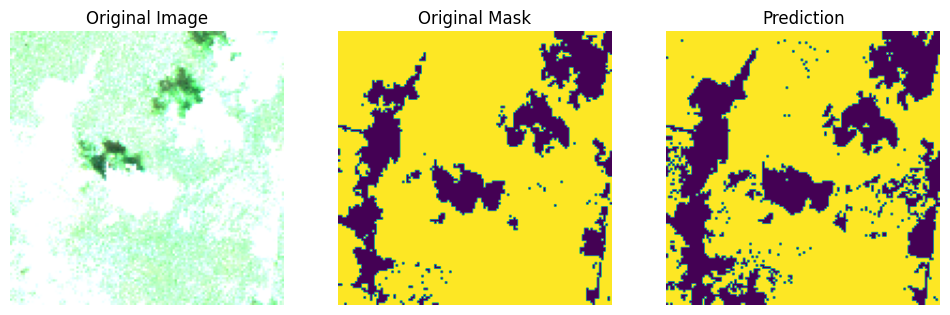

6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


[0.52874756 0.06365967] 
 [0.05004883 0.35754395]


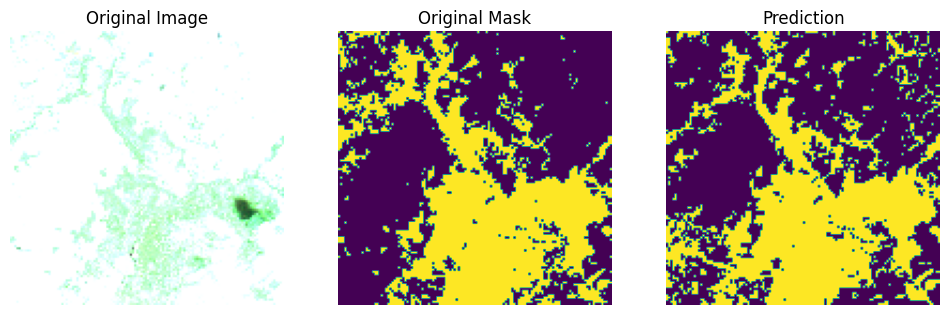

7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


[0.43713379 0.23876953] 
 [0.00054932 0.32354736]


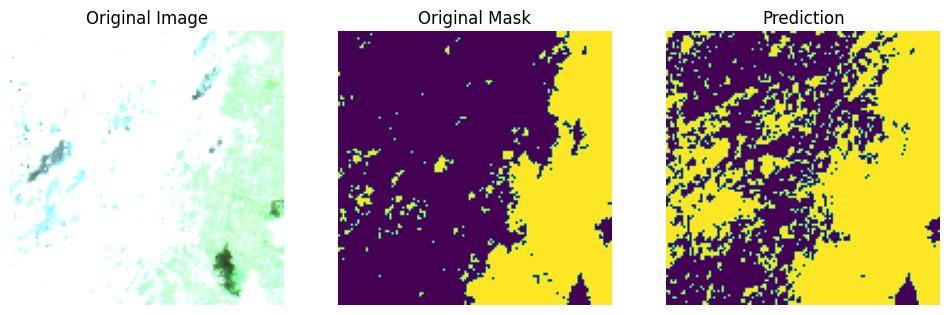

8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


[0.19287109 0.01306152] 
 [0.04803467 0.74603271]


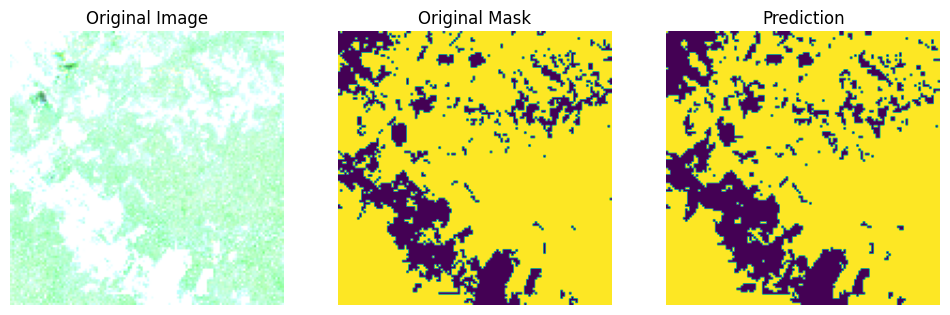

9
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


[0.70898438 0.02770996] 
 [0.10174561 0.16156006]


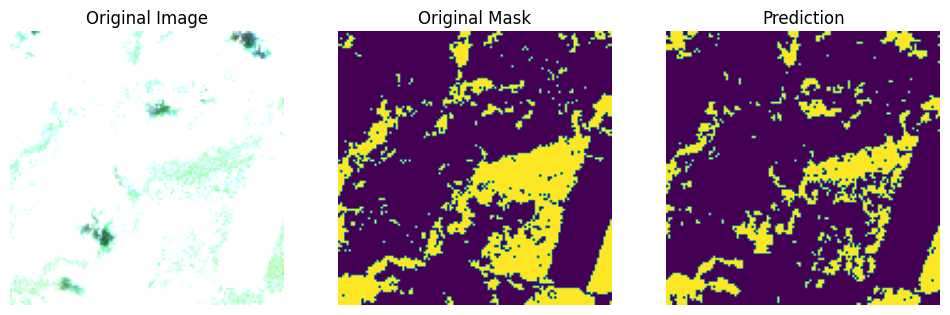

10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


[0.1051782  0.00548812] 
 [0.04771436 0.84161932]


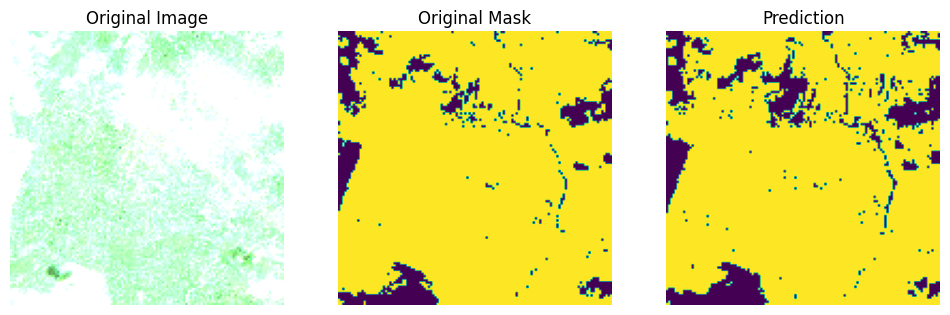

11
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


[0.3692627  0.10333252] 
 [0.01245117 0.51495361]


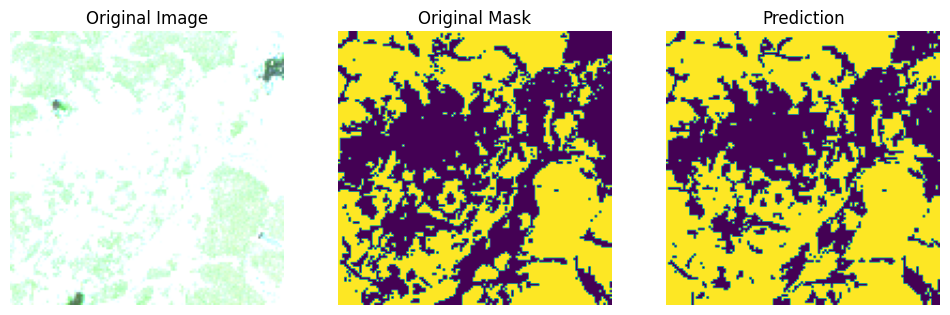

12
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


[0. 0.] 
 [0. 0.]


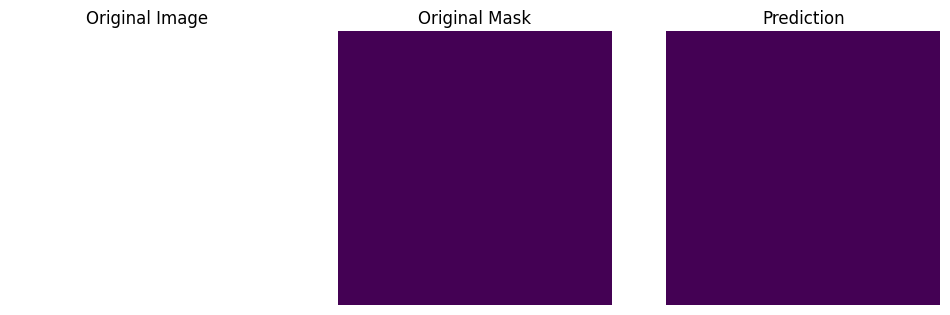

13
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


[0.79982776 0.0425689 ] 
 [0.0043061  0.15329724]


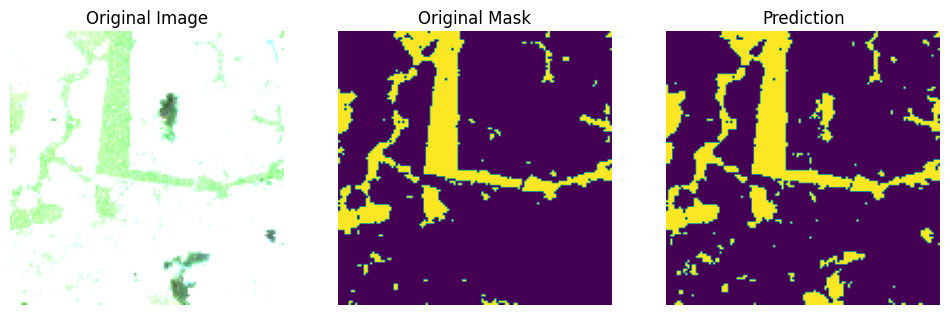

14
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


[0.44915675 0.02647569] 
 [0.0062624  0.51810516]


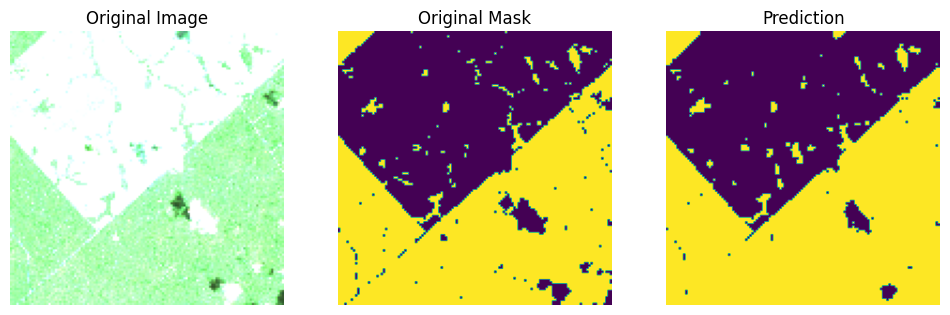

15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


[0.78033447 0.01556396] 
 [0.00689697 0.19720459]


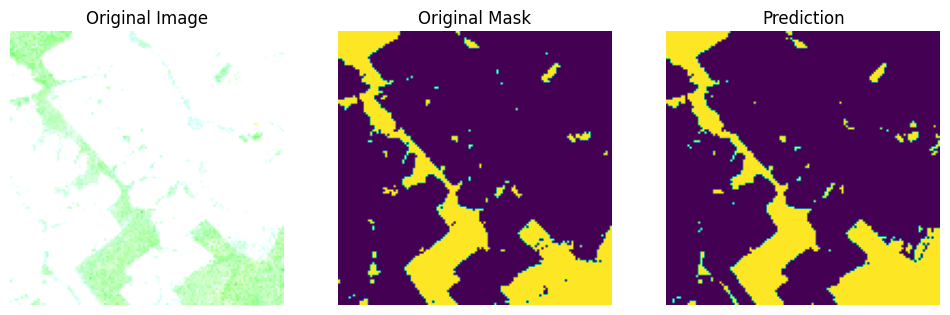

16
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


[0.6620935  0.01962652] 
 [0.01225864 0.30602134]


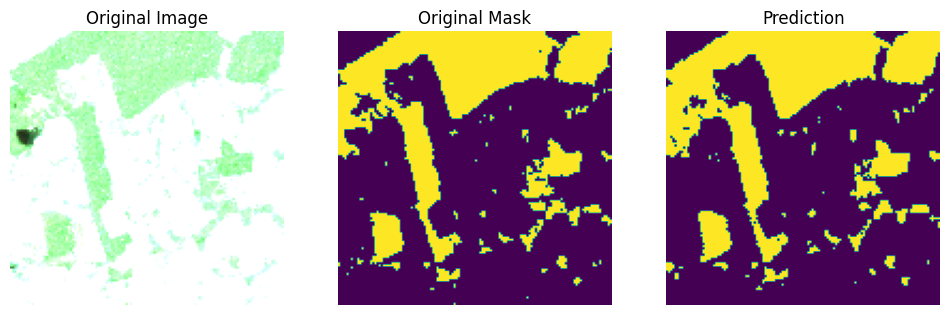

17
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


[0.83568548 0.01896421] 
 [0.00705645 0.13829385]


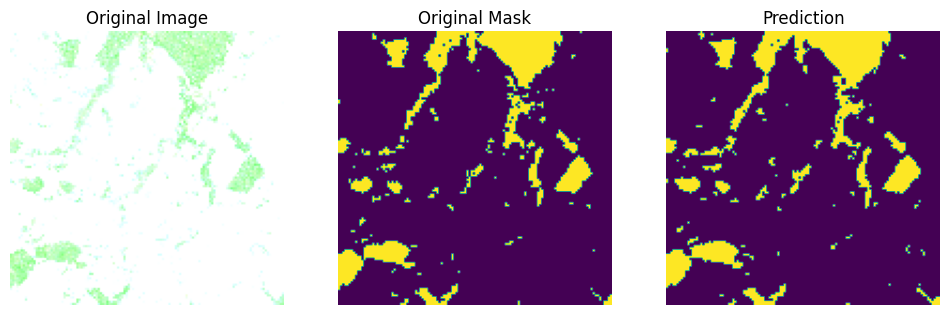

18
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


[0.74804688 0.01165771] 
 [0.00665283 0.23364258]


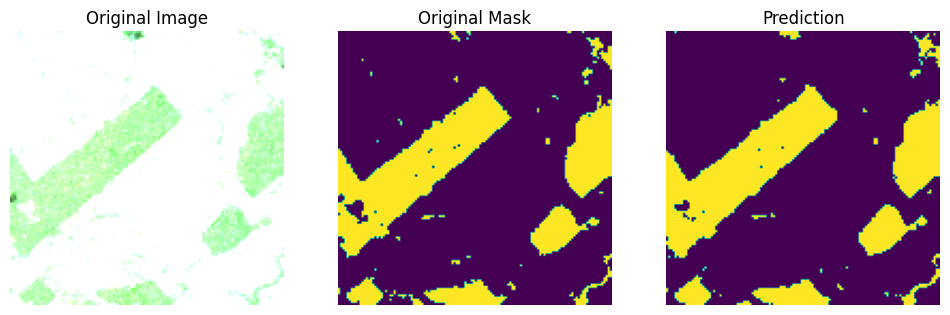

19
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


[0.58117676 0.06860352] 
 [0.02575684 0.32446289]


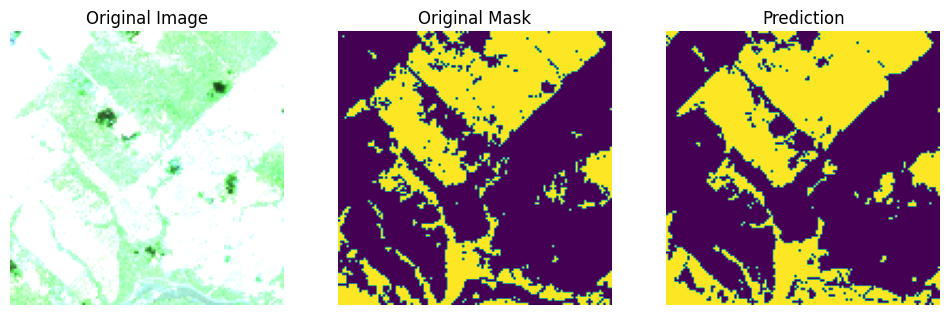

20
[[[[5235, 563], [262, 10324]], [[4448, 910], [254, 10772]], [[4530, 109], [828, 10917]], [[4423, 87], [911, 10963]], [[3311, 61], [1425, 11587]], [[8663, 1043], [820, 5858]], [[7162, 3912], [9, 5301]], [[3160, 214], [787, 12223]], [[11616, 454], [1667, 2647]], [[1629, 85], [739, 13035]], [[6050, 1693], [204, 8437]], [[0, 0], [0, 0]], [[13002, 692], [70, 2492]], [[7244, 427], [101, 8356]], [[12785, 255], [113, 3231]], [[10424, 309], [193, 4818]], [[13264, 301], [112, 2195]], [[12256, 191], [109, 3828]], [[9522, 1124], [422, 5316]], [[0, 0], [0, 0]]]]


In [62]:
dir = "/content/drive/MyDrive/Mestrado/2024_2/Qualification/adam_0.003_0.975_he_normal/"
diretorio = os.listdir(dir)
model = estimator# Assuming 'unet' is defined somewhere
todasMatrizes = []
print(diretorio)

for i in range(len(diretorio)):
    estimator.load_weights(dir + diretorio[i])
    matrizes = []
    matrizes2 = [[0, 0], [0, 0]]
    amostras = 20  # Number of test images to use
    index = 0

    for _ in range(amostras):
      # Load and preprocess the test image
      img_path = '/content/drive/MyDrive/IFES_2023/AMAZON/Backup_Dataset/Validation/images/' + validation_img_list[index]
      img = cv2.imread(img_path, 3)
      img = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH))
      img = img[np.newaxis, :, :, :]  # Add batch dimension

      # Make prediction using the loaded model
      predicted_img = model.predict(img)  # Predict on individual image

      #cv2.imwrite('/content/drive/MyDrive/IFES_2023/AMAZON/Backup_Dataset/Validation/images/masks/'+validation_img_list[index], predicted_img)

      plt.figure(figsize=(12, 12))
      image = cv2.imread('/content/drive/MyDrive/IFES_2023/AMAZON/Backup_Dataset/Validation/masks/'+validation_img_list[index], 2)
      image = cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH))
      image = image[np.newaxis, :, :]  # Add batch dimension
      image=image*255
      plt.subplot(1, 3, 1)
      plt.imshow(np.squeeze(img))
      plt.axis('off')
      plt.title('Original Image')

      plt.subplot(1, 3, 2)
      plt.imshow(np.squeeze(image))
      plt.axis('off')
      plt.title('Original Mask')
      list_arr = cv2.imread('/content/drive/MyDrive/IFES_2023/AMAZON/Backup_Dataset/Validation/masks/'+validation_img_list[index],0)
      list_arr = cv2.resize(list_arr, (IMG_HEIGHT, IMG_WIDTH)).tolist()
      #print(list_arr[0])

      predicted_img=(np.squeeze(predicted_img)>=0.5)
      plt.subplot(1, 3, 3)
      plt.imshow(np.squeeze(predicted_img) )
      plt.title('Prediction')
      plt.axis('off')



      # assuming the array is named 'arr'
      predicted_img = predicted_img.astype(np.int64)
      list_arr2 = predicted_img.tolist()
      #print(list_arr2[0])
      for i in range(len(list_arr)):
        cm = confusion_matrix(list_arr[i],list_arr2[i])
        if cm.shape == (2, 2):
          matrizes2[0][0]+=cm[0][0]
          matrizes2[0][1]+=cm[0][1]
          matrizes2[1][0]+=cm[1][0]
          matrizes2[1][1]+=cm[1][1]
          teste=np.cumsum(matrizes2)
      #print(teste[3])
      print(matrizes2[0]/teste[3],'\n',matrizes2[1]/teste[3])
      matrizes2=[[0,0],[0,0]]
      matrizes.append(matrizes2)
      plt.show()
      index += 1
      #print(index)
      print(index)
    todasMatrizes.append(matrizes)
    print(todasMatrizes)

In [67]:
sum_confusion_matrix = np.zeros_like(matrizes[0])

# iterate over all matrices and add them to the sum matrix
for matrizes in todasMatrizes:
  for matrix in matrizes:
      sum_confusion_matrix += matrix
val = sum_confusion_matrix[0][0]+sum_confusion_matrix[0][1]
val1 = sum_confusion_matrix[1][0]+sum_confusion_matrix[1][1]

In [68]:
TP=sum_confusion_matrix[0][0]
FP=sum_confusion_matrix[0][1]
FN=sum_confusion_matrix[1][0]
TN=sum_confusion_matrix[1][1]
print(TP,FP,FN,TN)

138724 12430 9026 132300


In [69]:
precisao = TP / (TP + FP)
recall = TP / (TP + FN)
F1_Score = 2 * (precisao * recall) / (precisao + recall)
acuracia = (TP+TN) / (TN+TP+FP+FN)
iou = TP / (TP + FP + FN)
print("Precisão: ",precisao,"\nRecall: ",recall,"\nF1_Score: ",F1_Score,"\nAcuracia: ",acuracia,"\nIoU: ",iou)

Precisão:  0.917765987006629 
Recall:  0.9389103214890017 
F1_Score:  0.9282177555335493 
Acuracia:  0.9266411378555799 
IoU:  0.8660506929704083


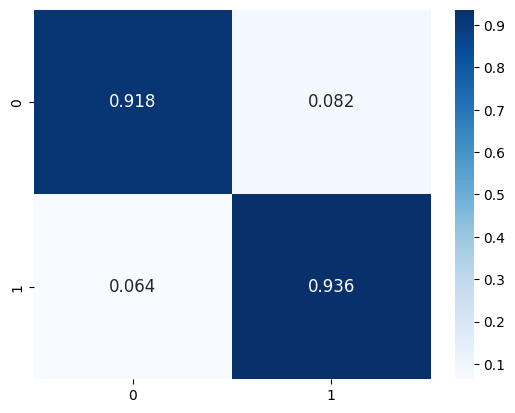

In [70]:
import seaborn as sns
matriz213 =[[TP/(TP + FP),FP/(TP + FP)],[FN/(FN+TN),TN/(FN+TN)]]
sns.heatmap(matriz213, annot=True,fmt=".3f", annot_kws={"size":12}, cmap=plt.cm.Blues)
plt.show()